## Import the necessary software libraries:

In [1]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # to view a progress bar

from envs import Maze
from utils import plot_policy, plot_tabular_cost_to_go, test_agent, plot_stats, seed_everything

## Implement state aggregation

<br><br>

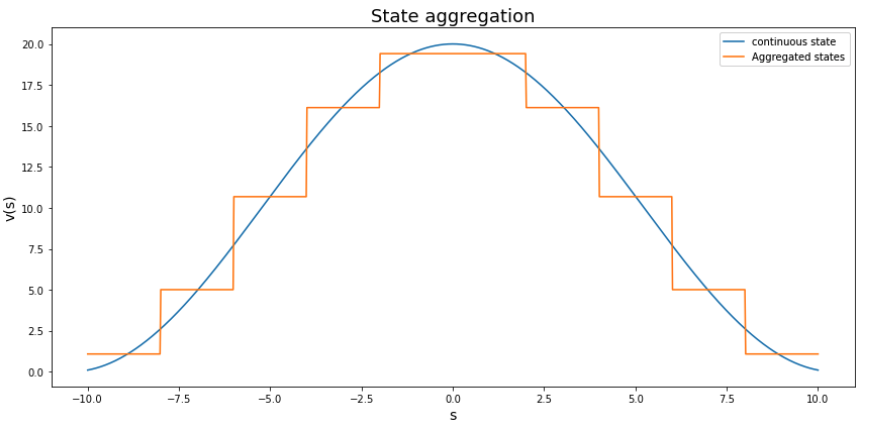

### Create the environment

In [2]:
# defining the control task
env = gym.make('MountainCar-v0')
seed_everything(env)  # it makes sure that everytime we execute this library, we obtain the same results

In [3]:
# first value represents position of the car on horizontal axis and 2nd value is velocity of car
env.reset() 

array([-0.5122243,  0.       ], dtype=float32)

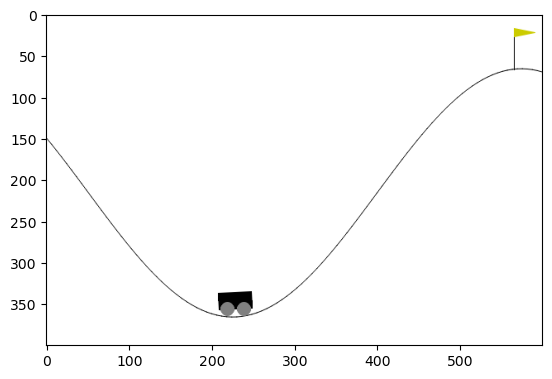

In [4]:
# graphic visualization of control task
frame = env.render(mode='rgb_array')
plt.imshow(frame)

### Create the state aggregation wrapper

In [5]:
# modifying the enovironment to generate dicrete states from the continuous one
# Observation Wrapper of gym library that will simplify applying modifications to the environment

class StateAggregationEnv(gym.ObservationWrapper):
    
    def __init__(self, env, bins, low, high): 
        # low = [-1.2, -0.07], high = [0.6, 0.07], bins = [20,20]
        # position of the car can take values from [-1.2, 0.6]
        # velocity of car can take values from -0.07 to 0.07
        # bins is the number of aggregated states we want for each variable i.e. 20
        
        super().__init__(env) # this will execute the __init__ method of ObservationWrapper
        
        # linspace function from numpy will take the ranges and divide them into 'b' aggregate states
        # we write 'b-1' because that's the format of this function
        self.buckets = [np.linspace(l, h, b-1) for l, h, b in zip(low, high, bins)] 
        
        # Changing the state space of our environment, value of bins converted to a list 
        # i.e. [0,0] to [20,20] -> 400 states
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist())
    
    # modifying the states of original environment
    # we override the observation method from the ObservationWrapper class
    def observation(self, state):
        # eg. state of car [-1.2, 0.] -> (4, 3)
        indices = tuple(np.digitize(cont, buck) for cont, buck in zip(state, self.buckets)) # 'cont' -> continuous value
        return indices
        
    

In [6]:
bins = np.array([20,20])
low = env.observation_space.low
high = env.observation_space.high
saenv = StateAggregationEnv(env, bins=bins, low=low, high=high)

In [7]:
saenv.buckets

[array([-1.20000005, -1.10000004, -1.00000004, -0.90000004, -0.80000003,
        -0.70000003, -0.60000002, -0.50000002, -0.40000002, -0.30000001,
        -0.20000001, -0.1       ,  0.        ,  0.1       ,  0.20000001,
         0.30000001,  0.40000002,  0.50000002,  0.60000002]),
 array([-0.07      , -0.06222222, -0.05444444, -0.04666667, -0.03888889,
        -0.03111111, -0.02333333, -0.01555556, -0.00777778,  0.        ,
         0.00777778,  0.01555556,  0.02333333,  0.03111111,  0.03888889,
         0.04666667,  0.05444444,  0.06222222,  0.07      ])]

### Compare the original environment to the one with aggregated states

In [8]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.observation_space.sample()}")

Original observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Sample state: [ 0.1931209  -0.00855702]


In [9]:
print(f"Modified observation space: {saenv.observation_space}, \n\
Sample state: {saenv.observation_space.sample()}")

Modified observation space: MultiDiscrete([20 20]), 
Sample state: [17  4]


### Create the $Q(s,a)$ value table

In [10]:
action_values = np.zeros((20,20, 3))

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [11]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

### Test the SARSA algorithm on the modified environment

In [12]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = saenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = saenv.step(action)
            next_action = policy(next_state, epsilon)
            
            qsa = action_values[state][action]
            next_qsa = action_values[next_state][next_action]
            action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [13]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

100%|████████████████████████████████████| 20000/20000 [01:28<00:00, 225.88it/s]


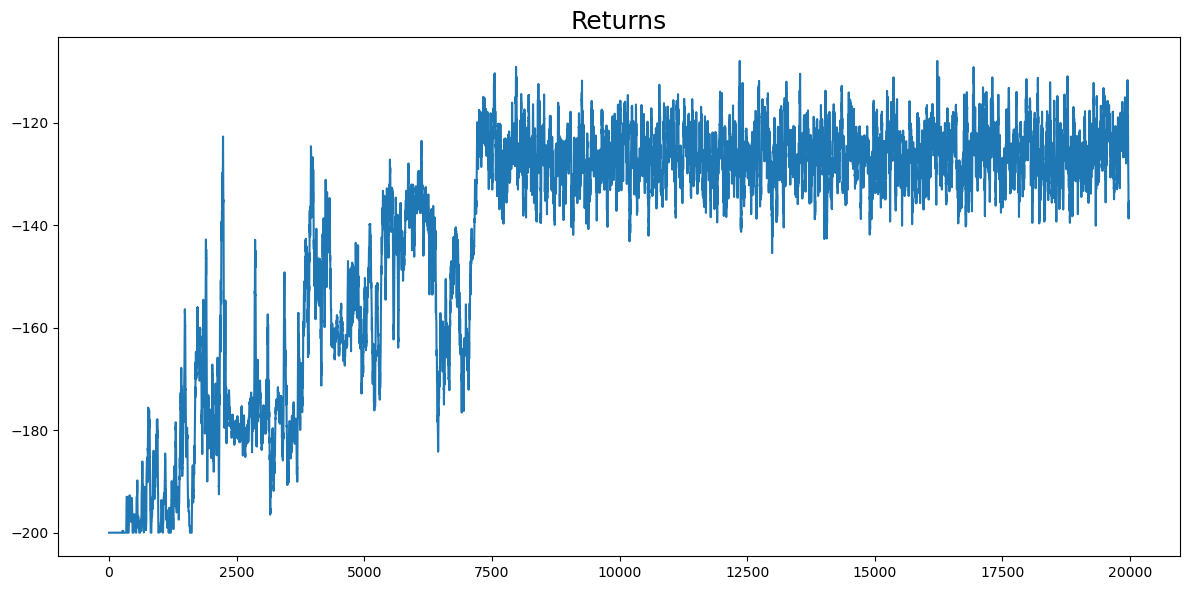

In [14]:
plot_stats(stats)

### Plot the learned policy: $\pi(s)$

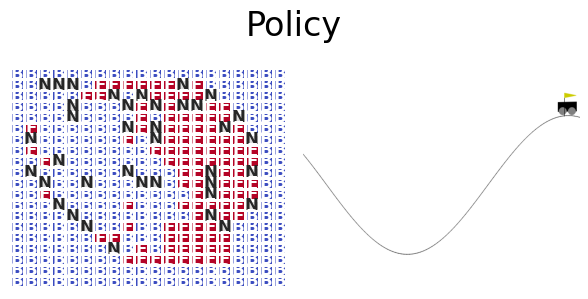

In [15]:
plot_policy(action_values, env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

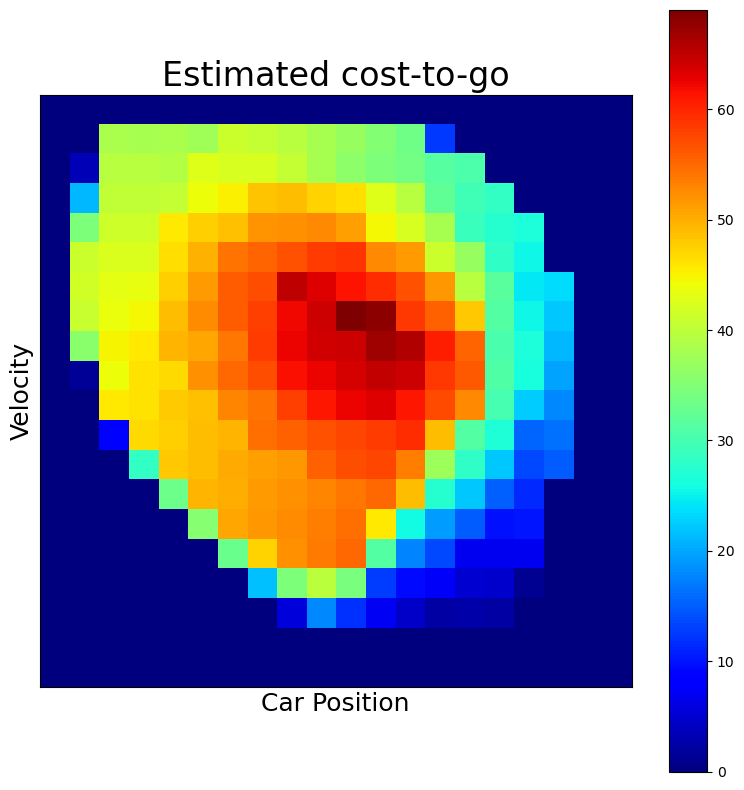

In [16]:
plot_tabular_cost_to_go(action_values, xlabel="Car Position", ylabel="Velocity")
# every square here is a state with combination of velocity and position
# this graph tells us the approx. cost of getting to the goal in terms of reward
# cost to go is maximum at the initial states

### Test the resulting policy

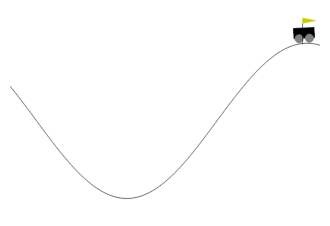

In [17]:
test_agent(saenv, policy, 2)

<br><br><br><br>

## Implement Tile Coding

<br><br>

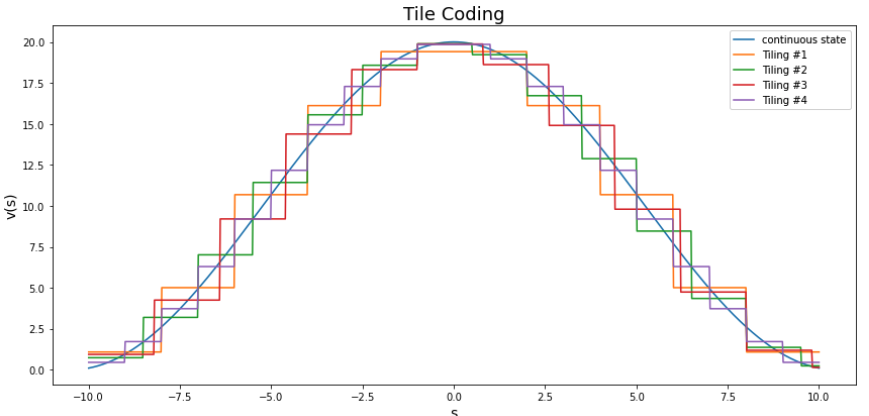

### Create the environment

In [18]:
env = gym.make('MountainCar-v0')
seed_everything(env)

### Create the Tile Coding wrapper

In [19]:
class TileCodingEnv(gym.ObservationWrapper):
    
    # Initialize the class
    def __init__(self, env, bins, low, high, n):
        super().__init__(env)
        self.tilings = self.create_tilings(bins, high, low, n)  # var to contain different state aggregations
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist() * n) # no. of dimensions of state with n state aggregations
        
    # Implement the observation method to modify the original state
    def observation(self,state):
        # e.g. [(5, 4), (5,3), (4,4)], say n=3 and we've 3 tilings
        indices = []
        for tiling in self.tilings:
            tiling_indices = tuple(np.digitize(i,b) for i, b in zip(state, tiling))
            indices.append(tiling_indices)
        
        return indices
    
    
    # Function to create separate tilings, each one of different state aggregations
    def create_tilings(self, bins, high, low, n):
        displacement_vector = np.arange(1, 2*len(bins), 2) # odd nos. starting at 1 upto 2*dimensions
        tilings = []
        
        for i in range(1, n+1):
            # where the dimension of the state begins, subtract a certain %, 
            # i.e. stretching the state aggregation to the left horizontally 
            low_i = low - random.random() * 0.2 * low
            
            high_i = high + random.random() * 0.2 * high # we chose 0.2 as we don't want it to move more than 20%
            
            # intervals of grouping
            segment_sizes = (high_i - low_i) / bins 
            
            displacements = displacement_vector * i % n # i modulo n
            displacements = displacements * (segment_sizes / n)
            low_i += displacements
            high_i += displacements 
            
            buckets_i = [np.linspace(l, h, b-1) for l, h, b in zip(low_i, high_i, bins)] 
            tilings.append(buckets_i)
        
        return tilings
    

In [20]:
tilings = 4
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high
tcenv = TileCodingEnv(env, bins=bins, low=low, high=high, n=tilings)

### Compare the original environment to the one with aggregated states

In [21]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.reset()}")

Original observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Sample state: [-0.5122243  0.       ]


In [22]:
print(f"Modified observation space: {tcenv.observation_space}, \n\
Sample state: {tcenv.reset()}")

Modified observation space: MultiDiscrete([20 20 20 20 20 20 20 20]), 
Sample state: [(8, 9), (6, 8), (7, 9), (8, 9)]


### Create the $Q(s,a)$ value table

In [23]:
action_values = np.zeros((4, 20, 20, 3)) # 4 bcoz 1 for each state aggregation and we put tilings=4

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [24]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av_list = []
        for i, idx in enumerate(state):
            av = action_values[i][idx]
            av_list.append(av)
        
        # why axis=0? bcoz if we don't give axis value, it will find mean of all values regardless of their location in list
        # eg. [[1,2,3],[4,5,6]] just mean will give mean with 1,2,3,4,5,6 a single value but we want an array with 3 elements [[2.5,3.5,4.5]]
        # i.e. list of each values separately
        av = np.mean(av_list, axis=0)
        return np.random.choice(np.flatnonzero(av==av.max()))
    

### Test the SARSA algorithm on the modified environment

In [25]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = tcenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = tcenv.step(action)
            next_action = policy(next_state, epsilon)
            
            for i, (idx, next_idx) in enumerate(zip(state, next_state)):
                qsa = action_values[i][idx][action]
                next_qsa = action_values[i][next_idx][next_action]
                action_values[i][idx][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [26]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

100%|████████████████████████████████████| 20000/20000 [02:49<00:00, 118.09it/s]


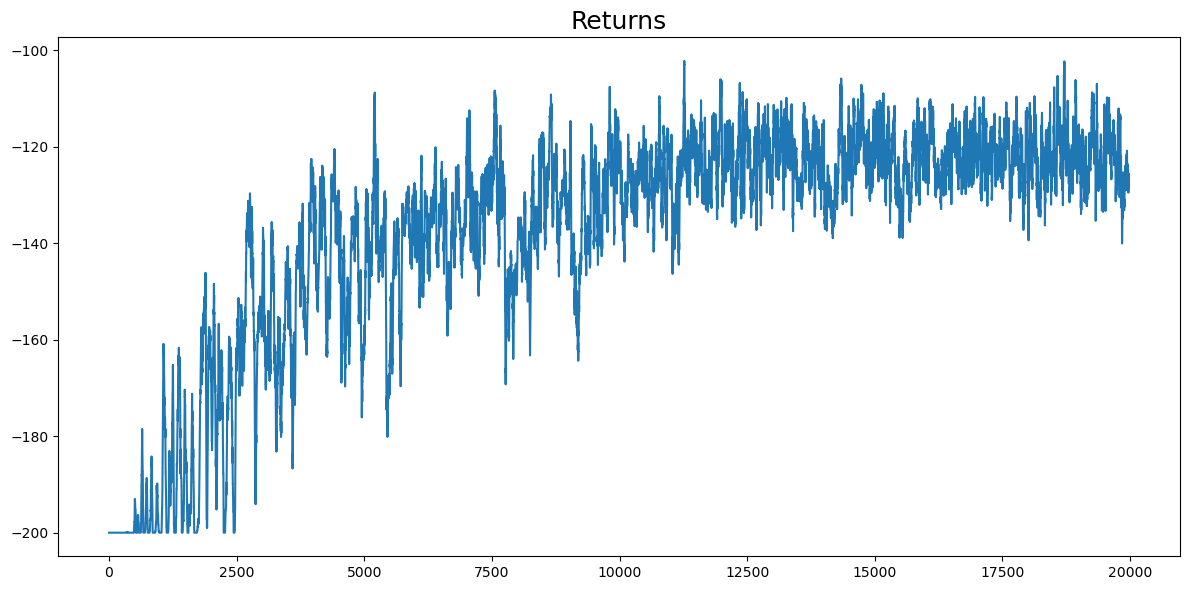

In [27]:
plot_stats(stats)

### Plot the learned policy: $\pi(s)$

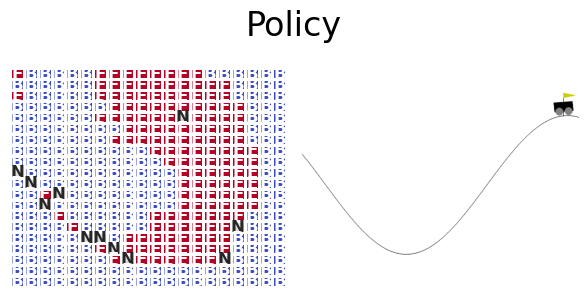

In [28]:
plot_policy(action_values.mean(axis=0), env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

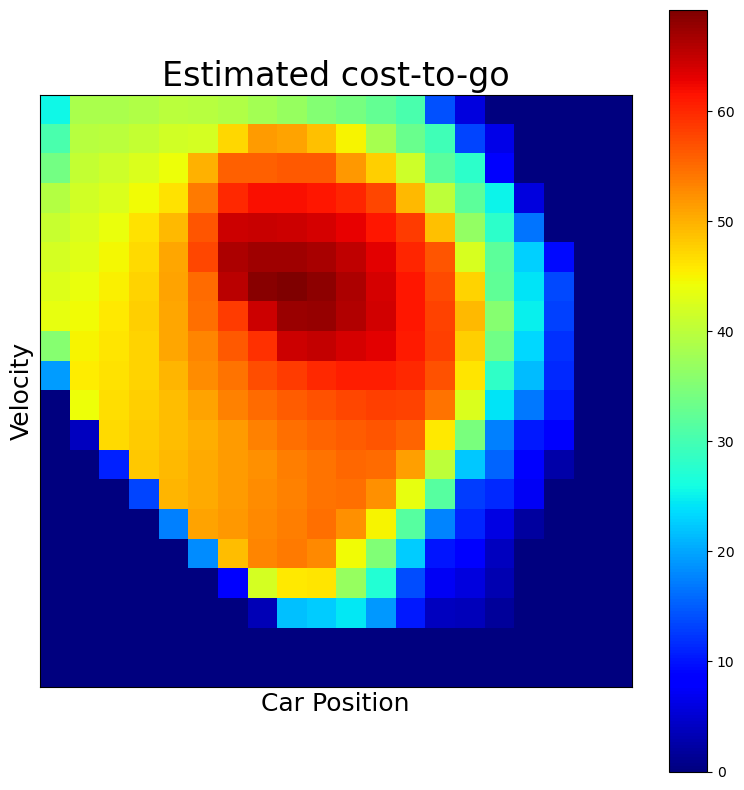

In [29]:
plot_tabular_cost_to_go(action_values.mean(axis=0), \
                        xlabel="Car Position", ylabel="Velocity")
# we obtain a much smoother estimate of adjacent cells and overall than when we used just state aggregation which had more jumps in values

### Test the resulting policy

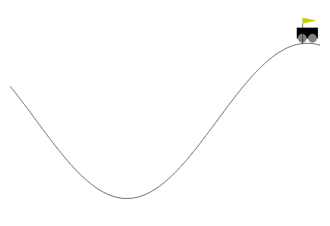

In [30]:
test_agent(tcenv, policy, 2)

## Resources

[[1] Reinforcement Learning: An Introduction. Section 9.5.4: Tile Coding](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)